In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl


In [2]:
total_count = 16


In [3]:


def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
        if not line.startswith('--') and 'current ops/sec; [UPDATE AverageLatency' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())
            latencies.append(line.split('=')[1].split(']')[0].strip())
            
            print(line,latencies[-1],thputs[-1],times[-1])

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  






def getTimeThps(file, flag):
    
    f = open(file, "r")
    data = f.readlines() 

    times = []
    thputs = []
    for line in data:
        if 'throughput[ops/s]' in line:
            lineData = (line[13+line.find('max[ops/s])>'):-2])
            print(lineData)

            times.append(lineData.split('|')[0])
            thputs.append(lineData.split('|')[-2])
    if (flag): 
        times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
        thputs.append(0)
        
    return np.array(times).astype(float), np.array(thputs).astype(float) 

In [4]:
# os.system("aws --region ap-south-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region ap-south-1 ec2 describe-instances --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")



# os.system("aws --region ap-south-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region ap-south-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

In [5]:
with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines, len(lines)

(['13.232.161.199',
  '3.109.132.130',
  '65.2.144.47',
  '13.233.50.137',
  '13.127.11.123',
  '43.205.144.148',
  '65.0.103.119',
  '15.207.85.182',
  '52.66.4.179',
  '65.0.205.146',
  '43.204.97.26',
  '65.1.147.48',
  '65.0.107.239',
  '15.207.55.215',
  '13.235.82.54',
  '13.233.104.38',
  '52.66.166.115',
  '13.233.163.121',
  '52.66.246.166',
  '13.235.76.115'],
 20)

In [6]:
for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

ssh -i "FinalKeys.pem" ubuntu@ec2-13-232-161-199.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-109-132-130.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-2-144-47.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-233-50-137.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-127-11-123.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-43-205-144-148.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-0-103-119.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-15-207-85-182.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-52-66-4-179.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-0-205-146.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-43-204-97-26.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-1-147-48.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-0-107-239.

In [7]:
## Set number of clusters

nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1
        
        
print(nclusters)




nreplicas = int(total_count/nclusters)
nodeIps = lines[:nclusters* nreplicas]

nclients = nclusters

# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]



# clientIps = lines[-(nclusters):]
clientIps = lines[-nclients:]



clientIps, no_cluster_yet_nodes

4


(['52.66.166.115', '13.233.163.121', '52.66.246.166', '13.235.76.115'], [])

In [8]:
## Functions

def setup(i):

    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:commands.sh'
        
        print(command)
        os.system(command)
        
def initialize(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t "sudo sh commands.sh"'
        
        
        os.system(command)
        
        
def git_clone(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'
        
        
        os.system(command)
        
def git_pull(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/BftSmart_Final; cd BftSmart_Final; sudo git pull"'
        
        
        os.system(command)
        
def compile_job(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo ./gradlew installDist"'
        
        
        os.system(command)

        
        
def clean_job(i):
    ip = lines[i]
    
    rm_command = 'sudo rm config/currentView; '
    for iter_ in range(nclusters):
        rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'
        
        
        os.system(command)
        
        
def clean_all(i):
    ip = lines[i]
    
    rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
        os.system(command)
        
def run_server_node(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)
        
        
        
    if ip!='None' and( ip in no_cluster_yet_nodes):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)        
#         print(command)

def check_node(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
        os.system(command)
#         print(command)


def run_basic_client(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
#     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
        current = (ip.split('.'))
        
#         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
        os.system(command)


def kill_java(i):
    ip = lines[i]
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)
        
        
        
def kill_clients(i):
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)

def run_server_node_check(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        print(command)
        
        

# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
        print(command)

In [9]:
# for i in range(len(lines)):
#     run_basic_client_check(i)
    

# def setup(i):

#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        
#         os.system(command)
        
# def initialize(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "sudo sh commands.sh"'
        
        
#         os.system(command)
        
        
# def git_clone(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t " sudo git clone https://tmane002@bitbucket.org/tmane002/BftSmart_Final.git"'
        
        
#         os.system(command)
        
# def git_pull(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/bftsmartt; cd bftsmartt; sudo git pull"'
        
        
#         os.system(command)
        
# def compile_job(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo ./gradlew installDist"'
        
        
#         os.system(command)

        
        
# def clean_job(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm config/currentView; '
#     for iter_ in range(nclusters):
#         rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; cd bftsmartt; '+rm_command+'"'
        
        
#         os.system(command)
        
        
# def clean_all(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm -r bftsmartt; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
#         os.system(command)
        
# def run_server_node(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)
        
        
        
#     if ip!='None' and( ip in no_cluster_yet_nodes):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)        
# #         print(command)

# def check_node(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
#         os.system(command)
# #         print(command)


# def run_basic_client(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
# #     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
#         current = (ip.split('.'))
        
# #         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
#         os.system(command)


# def kill_java(i):
#     ip = lines[i]
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)
        
        
        
# def kill_clients(i):
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)

# def run_server_node_check(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         print(command)
        
        

# # for i in range(len(lines)):
# #     run_server_node_check(i)

# def run_basic_client_check(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
#         print(command)

# # for i in range(len(lines)):
# #     run_basic_client_check(i)
    

In [10]:
## First Time Setup

lines, len(lines)

(['13.232.161.199',
  '3.109.132.130',
  '65.2.144.47',
  '13.233.50.137',
  '13.127.11.123',
  '43.205.144.148',
  '65.0.103.119',
  '15.207.85.182',
  '52.66.4.179',
  '65.0.205.146',
  '43.204.97.26',
  '65.1.147.48',
  '65.0.107.239',
  '15.207.55.215',
  '13.235.82.54',
  '13.233.104.38',
  '52.66.166.115',
  '13.233.163.121',
  '52.66.246.166',
  '13.235.76.115'],
 20)

In [11]:
# for i in range(10):
#     setup(i)


results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Warning: Permanently added 'ec2-43-204-97-26.ap-south-1.compute.amazonaws.com' (ED25519) to the list of known hosts.


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [12]:
results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be

Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease


fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Cloning into 'BftSmart_Final'...
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Cloning into 'BftSmart_Final'...
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://ap-south-1.ec2.archive.ubu

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Cloning into 'BftSmart_Final'...


Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu ja

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Fetched 108 kB in 1s (160 kB/s)
Reading package lists...Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Fetched 108 kB in 1s (170 kB/s)
Reading package lists...Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Fetched 226 kB in 1s (326 kB/s)
Reading package lists...Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Fetched 108 kB in 1s (165 kB/s)
Reading package lists...Fetched 108 kB in 1s (163 kB/s)
Reading package lists...Fetched 108 kB in 1s (161 kB/s)
Reading package lists...
Reading package lists...

Building dependency tree...
Reading package lists...
Building dependency tree...
Reading package lists...
Building dependency tree...Reading package lists...
Building dependency tree...
Reading st

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found



ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Building dependency tree...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Reading package lists...Reading package lists...

Building dependency tree...Building dependency tree...Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.

Reading state information...

Reading state information...
Reading package lists...
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Building dependency tree...
Reading state information...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]

Reading state information...

Reading state information...
Get:3 http://securi

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.

Reading state information...
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Fetched 218 kB in 1s (292 kB/s)
Reading package lists...

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [579 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Fetched 218 kB in 1s (297 kB/s)
Reading package lists...Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [799 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [202 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.4 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [580 kB]
iputils-ping is already the newest version (3:20211215-1).
0 up

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
Cloning into 'BftSmart_Final'...


Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [579 kB]
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/restricted amd64 c-n-f Metadata [116 B]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [22.2 kB]
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe Translation-en [15.4 kB]
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 c-n-f Metadata [580 B]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f M

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [204 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [20.7 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [9704 B]
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 c-n-f Metadata [476 B]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 Packages [40.9 kB]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main Translation-en [10.2 kB]
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 c-n-f Metadata [388 B]
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/restricted amd64 c-n-f Metadata [116 B]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu

Cloning into 'BftSmart_Final'...



Reading state information...
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [799 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [89.0 kB]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [202 kB]
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.4 kB]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [580 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f 

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+

Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubu

job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [142 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.0 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [568 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubun

Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [89.0 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [751 kB]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [134 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [15.8 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/mult

Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc-doc
  gcc-11-multilib glibc-doc bzr libgd-tools libstdc++-11-doc make-doc
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
0 upgraded, 52 newly installed, 0 to remove and 82 not upgraded.
Need to get 63.6 MB

Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2087 kB]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04.1 [2087 kB]
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.3.0-1ubuntu1~22.04.1 [11.4 MB]
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.3.0-1ubuntu1~22.04.1 [11.4 MB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Get:27 http://ap-south-1.ec2.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 63.6 MB in 3s (20.4 MB/s)
Selecting previously unselected package libc-dev-bin.
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Fetched 26.0 MB in 5s (5007 kB/s)
Fetched 26.0 MB in 5s (5228 kB/s)database ... 85%
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../01-linux-libc-dev_5.15.0-76.83_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.15.0-76.83) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../01-linux-libc-dev_5.15.0-76.83_amd64.deb ...
Unpacking linux-libc-dev:am

Preparing to unpack .../07-gcc-11-base_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...

The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
Selecting previously unselected package libisl23:amd64.
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Unpacking libisl23:amd64 (0.24-2build1) ...
Selecting previously unselect

Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../13-libgomp1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
0 upgraded, 52 newly installed, 0 to remove and 82 not upgraded.
Need to get 63.6 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-dev-bin amd64 2.35-0ubuntu3.1 [20.4 kB]
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../12-libcc1-0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Get:5 http://

Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.3.0-1ubuntu1~22.04.1 [9968 kB]
Selecting previously unselected package libquadmath0:amd64.
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../20-libquadmath0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../19-libubsan1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.1.0-2ubuntu1~22.04 [1069 kB]
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04.1 [20.1 MB]
Selecting previously unselected package libgcc-11-dev:amd64.
Preparing to unpack .../21-libgcc-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.

Unpacking bzip2 (1.0.8-5build1) ...
Get:37 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:38 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Selecting previously unselected package g++.
Get:39 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Get:40 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:41 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-4.2ubuntu5 [131 kB]
Get:42 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg-turbo8 amd64 2.1.2-0ubuntu1 [134 kB]
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Get:43 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg8 amd64 8c-2ubuntu10 [2264 B]
Unpacking g++ (4:11.2.0-1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:36 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1041 kB]
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Unpacking bzip2 (1.0.8-5build1) ...
Get:37 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:38 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Get:39 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Get:40 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:41 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-4.2ubuntu5 [131 kB]
Get:42 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg-turbo8 amd64 2.1.2-0ubuntu1 [134 kB]
Get:43 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking linux-libc-dev:amd64 (5.15.0-76.83) ...
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Fetched 63.6 MB in 3s (18.5 MB/s)
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.3.0-1ubuntu1~22.04.1 [20.9 kB]
Selecting previously unselected package libc-dev-bin.
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Selecting previously unselected package fontconfig-config.
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package libfontconfig1:amd64.
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl23 amd64 0.24-2build1 [727 kB]
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../01-linux-libc-d

Selecting previously unselected package libc-devtools.
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc-devtools (2.35-0ubuntu3.1) ...
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Selecting previously unselected package libmpc3:amd64.
Selecting previously unselected package rpcsvc-proto.
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build7) ...
Selecting previously unselected package cpp-11.
Selecting previously unselected package libtirpc-dev:amd64.
Preparing to unpack .../10

Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Selecting previously unselected package libasan6:amd64.
Setting up fonts-dejavu-core (2.37-2build1) ...
Preparing to unpack .../16-libasan6_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Setting up cpp-11 (11.3.0-1ubuntu1~22.04.1) ...
Unpacking libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libcc1-0:amd64.
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../12-libcc1-0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../20-libquadmath0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Selecting previously unselected package libgcc-11-dev:amd64.
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../21-libg

Selecting previously unselected package g++-11.
Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.3.0-1ubuntu1~22.04.1 [9968 kB]
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package g++-11.
Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package gcc.
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Preparing to unpack .../24-libstdc++-11-dev_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previou

Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Selecting previously unselected package libjpeg8:amd64.
Selecting previously unselected package bzip2.
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Unpacking bzip2 (1.0.8-5build1) ...
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Selecting previously unselected package libdef

Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc-devtools (2.35-0ubuntu3.1) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build7) ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package manpages-dev.
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Unpacking manpages-dev (5.10-1ubuntu1) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking libjpeg-tur

Setting up libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up cpp-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Setting up gcc (4:11.2.0-1ubuntu1) ...
Setting up libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Setting up gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Setting up g++-11 (11.3.0-1ubuntu1~22.04.1) ...
Setting up libc6-dev:am

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Fetched 484 kB in 1s (946 kB/s)
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.1.0-2ubuntu1~22.04 [154 kB]
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Processing triggers for libc-bin (2.35-0ubu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04.1 [20.1 MB]
Fetched 484 kB in 1s (943 kB/s)
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Processing triggers for man-db (2.10.2-1) ...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Processing triggers f

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgraphite2-3 amd64 1.3.14-1build2 [71.3 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libharfbuzz0b amd64 2.7.4-1ubuntu3.1 [352 kB]
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libpcsclite1 amd64 1.9.5-3 [19.9 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-jre-headless amd64 11.0.19+7~us1-0ubuntu1~22.04.1 [42.5 MB]
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up curl (7.81.0-1ubuntu1.13) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outda

job.sh: 11: sdk: not found


Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2-data all 1.2.6.1-1ubuntu1 [19.1 kB]
Get:33 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 dpkg-dev all 1.21.1ubuntu2.2 [922 kB]
Get:33 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Get:34 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 kB]

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                   

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found



Reading state information...
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns

Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.7 [41.8 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common-data amd64 0.8-5ubuntu5.1 [23.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common3 amd64 0.8-5ubuntu5.1 [23.7 kB]
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-client3 amd64 0.8-5ubuntu5.1 [28.0 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcups2 amd64 2.4.1op1-1ubuntu4.4 [264 kB]
Preparing to unpack .../14-openjdk-11-jre-headless_11.0

job.sh: 11: sdk: not found


Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common-data amd64 0.8-5ubuntu5.1 [23.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common3 amd64 0.8-5ubuntu5.1 [23.7 kB]

Reading state information...
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Get:38 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Fetched 46.3 MB in 2s (20.0 MB/s)
Selecting previously unselected package alsa-topology-conf.Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libpcsclite1 amd64 1.9.5-3 [19.9 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Selecting previously unselected package java-common.
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Unpacking java-common (0.72build2) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Selecting previously unselected package libavahi-common-data:amd64.
Sel

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Setting up default-jre-headless (2:1.11-72build2) ...
Selecting previously unselected package alsa-topology-conf.
Setting up openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Get:34 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 kB]
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-op

Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:Certigna.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Get:36 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1041 kB]
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Get:50 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-up

Setting up ca-certificates-java (20190909ubuntu1.2) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:Cybertrust_Global_Root.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Adding debian:Comodo_AAA_Services_root.pem
Get:39 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Get:40 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:41 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-4.2ubuntu5 [131 kB]
done.
Setting up ant-optional (1.10.12-1) ...
Processing triggers for ca-certificates (

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package linux-libc-dev:amd64.
Fetched 63.6 MB in 29s (2185 kB/s)
Preparing to unpack .../01-linux-libc-dev_5.15.0-76.83_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.15.0-76.83) ...Get:43 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg8 amd64 8c-2ubuntu10 [2264 B]
Get:44 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libdeflate0 amd64 1.10-2 [70.9 kB]
Get:45 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libjbig0 amd64 2.1-3.1ubuntu0.22.04.1 [29.2 kB]
Get:46 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libwebp7 amd64 1.2.2-2ubuntu0.22.04.1 [206 kB]

Selecting previously unselected package libc-dev-bin.
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Get:47 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtiff5 amd64 4.3.0-6ubuntu0.4 [183 kB]
Get:48 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-

0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:NAVER_Global_Root_Certification_Authority.pem

Adding debian:COMODO_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Selecting previously unselected package rpcsvc-proto.
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:GlobalSign_Root_CA.pem
Selecting previously unselected package libtirpc-dev:amd64.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Selecting previously unselected package gcc-11-base:amd64.
Adding debian:Starfield_Class_2_CA.pem
Unpacking libtirpc-dev:amd64 (1.

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../14-libitm1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../15-libatomic1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libasan6:amd64.
Preparing to unpack .../16-libasan6_11.3.0-1ubuntu1~22.04.1_amd64.deb ...
Unpacking libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../17-liblsan0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Selecting previously unselected package bzip2.
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Unpacking bzip2 (1.0.8-5build1) ...
Reading package lists...
Building dependency tree...Selecting previously unselected package lto-disabled-list.
Preparing to unpack .../30-lto-disabled-list_24_all.deb ...
Unpacking lto-disabled-list (24) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../12-libcc1-0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../13-libgomp1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../14-libitm1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../15-libatomic1_12.1.0-2ubun

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Get:51 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfile-fcntllock-perl amd64 0.22-3build7 [33.9 kB]
Get:52 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 manpages-dev all 5.10-1ubuntu1 [2309 kB]
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Reading package lists...
Building dependency tree...
Reading state information...
Get:50 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/ma

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...Selecting previously unselected package libcrypt-dev:amd64.

Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Setting up gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Selecting previously unselected package libwebp7:amd64.
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Setting up manpages-dev (5.10-1ubuntu1) ...
Selecting previously unselected package rpcsvc-proto.
Selecting previously unselected package default-jre-headless.
Setting up lto-disabled-list (24) ...
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...

Unpacking default-jre-headless (2:1.11-72build2) ...
U

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...eparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...(Reading database ... 60%


Unpacking ant-optional (1.10.12-1) ...
Selecting previously unselected package libgd3:amd64.
Setting up libasan6:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Selecting previously unselected package libc6-dev:amd64.
Setting up fakeroot (1.28-1ubuntu1) ...
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Selecting previously unselected package libc-devtools.
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc-devtools (2.35-0ubuntu3.1) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Set

Setting up ca-certificates-java (20190909ubuntu1.2) ...
Setting up build-essential (12.9ubuntu3) ...
Selecting previously unselected package libisl23:amd64.
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Processing triggers for man-db (2.10.2-1) ...
Unpacking libisl23:amd64 (0.24-2build1) ...
Selecting previously unselected package libatomic1:amd64.
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Preparing to unpack .../15-libatomic1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Setting up libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
Selecting previously unselected package libasan6:amd64.
Setting up libnsl-dev:amd64 (1.3.

Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:Certigna.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:GlobalSign_Root_CA_-_R6.pemSelecting previously unselected package libubsan1:amd64.

Adding debian:SwissSign_Gold_CA_-_G2.pem
Preparing to unpack .../19-libubsan1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:Hongkong_Post_Root_C

Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Selecting previously unselected package libfakeroot:amd64.
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package fakeroot.
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Selecting previously unselected package fonts-dejavu-core.
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Un

2 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Setting up libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Setting up libisl23:amd64 (0.24-2build1) ...
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Setting up libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libgcc-1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up g++ (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...

Reading state information...
Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04.1) ...
Setting up build-essential (12.9ubuntu3) ...
Setting up gcc-11 (11.3.0-1ubuntu1~22.04.1) ...
Processing triggers for man-db (2.10.2-1) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Setting up gcc (4:11.2.0-1ubuntu1) ...Processing triggers for man-db (2.10.2-1) ...

Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Setting up libstdc++-11-dev:amd64 (11.3.0-1ubuntu

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outda

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Running kernel seems to be up-to-date.

No services need to be restarted.

Running kernel seems to be up-to-date.


No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Selecting previously unselected package java-common.
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Unpacking java-common (0.72build2) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unsel

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Selecting previously unselected package ant.
Selecting previously unselected package ant-optional.
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
Unpacking ant (1.10.12-1) ...
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
0 upgraded, 18 newly installed, 0 to remove and 80 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Selecting previously unselected package ant-optional.
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up java-common (0.72build2) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up libavahi-common-data:amd

Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:GTS_Root_R1.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:GTS_Root_R1.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:Certigna.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068

Reading package lists...
Building dependency tree...
Reading state information...
Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Fetched 46.3 MB in 15s (3097 kB/s)
Selecting previously unselected package alsa-topology-conf.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../12-libharfbuzz0b_2.7.4-1ubuntu3.1_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Selecting previously unselected package java-common.
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Unpacking java-common (0.72build2) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libcups2:amd64.
Preparing 

Adding debian:GlobalSign_Root_CA_-_R2.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:Network_Solutions_Certificate_Authority.pem
Selecting previously unselected package default-jre-headless.
Adding debian:COMODO_RSA_Certification_Authority.pem
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72build2) ...
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Selecting previously unselected package ant.
Adding debian:Security_Communication_RootCA2.pem
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem

Unpacking ant (1.10.12-1) ...
Adding debian:Cybertrust_Global_Root.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:IdenTrust_Public

Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:Secure_Global_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:GTS_Root_R4.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:GlobalSign_Root_CA_-_R2.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


In [13]:
## GIT Clone/Pull



results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such 

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [14]:
## Compile Job

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
print(results)  

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.

Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated A


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar

> Task :compileJava
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources N

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


.............................Starting a Gradle Daemon (subsequent builds will be faster)
................................10%....................10%..10%.....10%......10%.........10%........................10%........10%......10%........10%..............................20%.........20%.20%.................20%.........20%................30%.....20%.............30.30%.%...........................30%.............30%.20%.........20%....20%...40%...........30%............40%.....................20%...........40%...........40..%.....30%......30%..............30.%.50%...................40......%....................50%.........30%..........50%....40...%....40%.40%..........50%......60%...40%.........................................50%....40%.....................50%.60%....60%...........70%.....50%..............60%......50%..........................50....................%.....70%.....80.%..60....60%....%...70%.............70%...................60%...........80%................70%.....70%.........

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 5s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 1m 4s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 4s
3 actionable tasks: 3 executed

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operati


> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 14s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 15s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 17s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 1m 17s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 17s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 1m 17s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 19s
3 actionable tasks: 3 executed

In [15]:
## CLEAN SERVERS

results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory


In [16]:
## Setup Client and nodeIPS
len(nodeIps), len(clientIps)

(16, 4)

In [17]:
# ## RUN SERVERS

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  

# ### CHECK NODE RESULT

# check_node(7)

# ## Run basic client

# # time.sleep(20)
# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(0)

# time.sleep(60)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

In [18]:
## Main Job

# os.system('git add .; git commit -m "test";git push')

experiment = 'TestRun'+str(total_count)

In [19]:
results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# print(results) 




results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  


print('XXXXXXXX Started Servers XXXXXXXXXXXX')

time.sleep(40)

check_node(7)



print('XXXXXXXX Started Clients XXXXXXXXXXXX')

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
time.sleep(85)

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.

Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated AP


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 

> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actio

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated A

> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :compileJava
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar
> Task :installDist
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :compileJava

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed


rm: cannot remove 'nohup.out': No such file or directoryrm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory

rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remov

XXXXXXXX Started Servers XXXXXXXXXXXX
XXXXXXXX Started Clients XXXXXXXXXXXX
config+cinfo.getClusterNumber(id) is: config1
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) are: 11071, /172.31.44.219
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 0
-- Getting connection for remoteId: 0
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:0  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@2b4bac49
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 1
-- Getting connection for remoteId: 1
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@484970b0
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 2
-- Getting conne

nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found


In [20]:
if not os.path.exists('../Experiments/'+experiment):
    os.mkdir('../Experiments/'+experiment)

os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

for ip in nodeIps[:1]:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
#         print(command)
        os.system(command)

        
for ip in no_cluster_yet_nodes:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        

for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
        print(command)
        os.system(command)

rm: cannot remove '*': No such file or directory
rm: cannot remove 'TestRun16.png': No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory


scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-52-66-166-115.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/TestRun16/nohup_client_16.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-13-233-163-121.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/TestRun16/nohup_client_17.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-52-66-246-166.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/TestRun16/nohup_client_18.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-13-235-76-115.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/TestRun16/nohup_client_19.out


 6 sec: 17 operations; 16.88 current ops/sec; [UPDATE AverageLatency(us)=1524898] -- Sending request (ORDERED_REQUEST) with reqId=1
 1524898 16.88 6
 7 sec: 211 operations; 191.7 current ops/sec; [UPDATE AverageLatency(us)=1154121.9] 
 1154121.9 191.7 7
 8 sec: 411 operations; 199.8 current ops/sec; [UPDATE AverageLatency(us)=481792.64] 
 481792.64 199.8 8
 9 sec: 592 operations; 181 current ops/sec; [UPDATE AverageLatency(us)=436466.35] 
 436466.35 181 9
 10 sec: 744 operations; 151.85 current ops/sec; [UPDATE AverageLatency(us)=737483.1] 
 737483.1 151.85 10
 11 sec: 931 operations; 186.63 current ops/sec; [UPDATE AverageLatency(us)=533313.76] 
 533313.76 186.63 11
 12 sec: 1135 operations; 202.58 current ops/sec; [UPDATE AverageLatency(us)=487839.6] 
 487839.6 202.58 12
 13 sec: 1411 operations; 276 current ops/sec; [UPDATE AverageLatency(us)=387151.63] 
 387151.63 276 13
 14 sec: 1644 operations; 232.77 current ops/sec; [UPDATE AverageLatency(us)=415873.86] 
 415873.86 232.77 14
 1

 6 sec: 164 operations; 163.84 current ops/sec; [UPDATE AverageLatency(us)=1134381.59] 
 1134381.59 163.84 6
 7 sec: 401 operations; 217.63 current ops/sec; [UPDATE AverageLatency(us)=406468.9] 
 406468.9 217.63 7
 8 sec: 701 operations; 299.7 current ops/sec; [UPDATE AverageLatency(us)=402848.64] 
 402848.64 299.7 8
 9 sec: 1001 operations; 300 current ops/sec; [UPDATE AverageLatency(us)=294933.97] 
 294933.97 300 9
 10 sec: 1502 operations; 500.5 current ops/sec; [UPDATE AverageLatency(us)=214242.66] 
 214242.66 500.5 10
 11 sec: 2102 operations; 600 current ops/sec; [UPDATE AverageLatency(us)=177832.2] 
 177832.2 600 11
 12 sec: 2802 operations; 700 current ops/sec; [UPDATE AverageLatency(us)=134354.01] 
 134354.01 700 12
 13 sec: 3488 operations; 685.31 current ops/sec; [UPDATE AverageLatency(us)=148941.51] 
 148941.51 685.31 13
 14 sec: 4163 operations; 675 current ops/sec; [UPDATE AverageLatency(us)=155499.64] 
 155499.64 675 14
 15 sec: 4970 operations; 806.19 current ops/sec; [

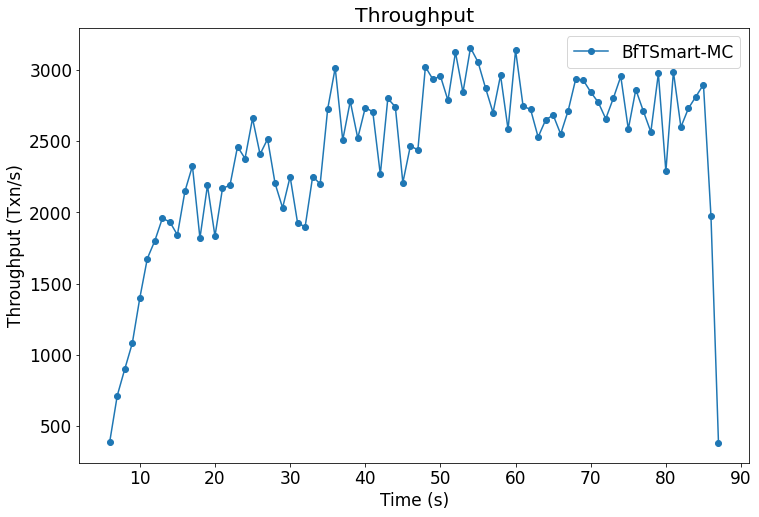

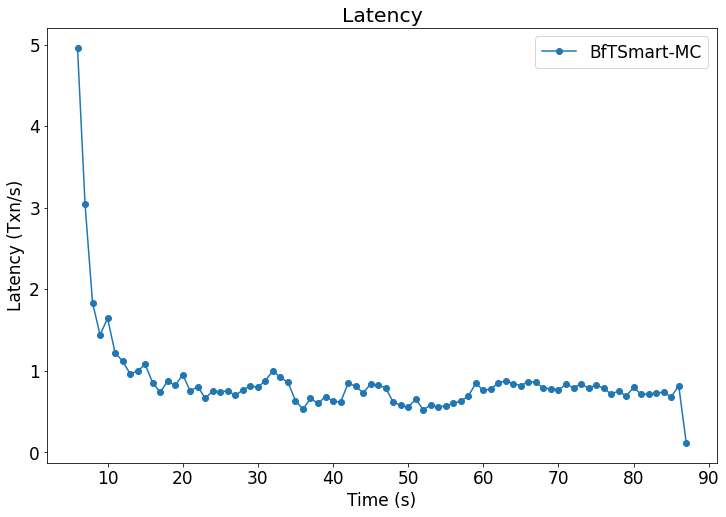

In [21]:
times_thputsDict = {}
times_latsDict = {}

for ip in clientIps[:1]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        times_thputsDict[times[i]] = thputs[i]
        times_latsDict[times[i]] = lats[i]
        

for ip in clientIps[1:]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        
        if times[i] in times_thputsDict.keys():
            times_thputsDict[times[i]] += thputs[i]
            
        if times[i] in times_latsDict.keys():
            times_latsDict[times[i]] += lats[i]
    

PIK = '../Experiments/'+experiment+"/pickle.dat"

data = [times_thputsDict, times_latsDict]

with open(PIK, "wb") as f:
    pickle.dump(data, f)


data2 = []
with open(PIK, "rb") as f:
    data2 =  pickle.load(f)


dict1 = data2[0]
dict2 = data2[1]



times1 = np.array(list(dict1.keys()))
thputs = np.array(list(dict1.values()))

times2 = np.array(list(dict2.keys()))
lats = np.array(list(dict2.values()))

times1

import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Throughput')


pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
pl.show()




pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], lats[:], '-o', label='BfTSmart-MC')


pl.title(r'Latency')


pl.xlabel('Time (s)')
pl.ylabel('Latency (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
pl.show()

In [22]:
lats

array([4.96201041, 3.04648231, 1.83442645, 1.43970188, 1.64274504,
       1.21921518, 1.11785837, 0.9622049 , 0.99715322, 1.07719818,
       0.85286798, 0.73553679, 0.87332405, 0.81945479, 0.95161539,
       0.75276573, 0.80437035, 0.6618689 , 0.75279751, 0.73699116,
       0.75548849, 0.69698589, 0.76493697, 0.81249826, 0.79694781,
       0.87956384, 0.99965814, 0.9192828 , 0.85757429, 0.63483498,
       0.5274831 , 0.66089984, 0.59961367, 0.68235861, 0.6305592 ,
       0.61322101, 0.84456701, 0.81325467, 0.72842955, 0.83505829,
       0.82083397, 0.79149011, 0.61444417, 0.57797668, 0.55220133,
       0.65311041, 0.52190555, 0.57868681, 0.55453048, 0.56838071,
       0.60088269, 0.628714  , 0.6878621 , 0.8478194 , 0.7584091 ,
       0.77771399, 0.85019392, 0.87565445, 0.84155775, 0.81818889,
       0.86586658, 0.85659478, 0.78358447, 0.78205622, 0.76322609,
       0.83506151, 0.79123   , 0.83828869, 0.78650638, 0.82474982,
       0.78337609, 0.7165575 , 0.74919729, 0.69028767, 0.79506

In [23]:
np.sum(thputs)

198479.01000000004

In [24]:
# np.average(lats[-50:]), np.average(thputs[-50:]) # (0.0542783668, 166.87759999999997)

In [25]:
# ## Main Job

# # os.system('git add .; git commit -m "test";git push')

# experiment = 'RemoveViewChangeBftSmartMC'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(125)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
#         print(command)
#         os.system(command)

# times_thputsDict = {}
# times_latsDict = {}

# for ip in clientIps[:1]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
#         times_thputsDict[times[i]] = thputs[i]
#         times_latsDict[times[i]] = lats[i]
        

# for ip in clientIps[1:]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
        
#         if times[i] in times_thputsDict.keys():
#             times_thputsDict[times[i]] += thputs[i]
            
#         if times[i] in times_latsDict.keys():
#             times_latsDict[times[i]] += lats[i]
    

# PIK = '../Experiments/'+experiment+"/pickle.dat"

# data = [times_thputsDict, times_latsDict]

# with open(PIK, "wb") as f:
#     pickle.dump(data, f)


# data2 = []
# with open(PIK, "rb") as f:
#     data2 =  pickle.load(f)


# dict1 = data2[0]
# dict2 = data2[1]



# times1 = np.array(list(dict1.keys()))
# thputs = np.array(list(dict1.values()))

# times2 = np.array(list(dict2.keys()))
# lats = np.array(list(dict2.values()))

# times1


# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Remote View Change for BftSmart-MC with timeout = 20 s')


# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
# pl.show()

In [26]:
# ## Main Job

# # os.system('git add .; git commit -m "test";git push')

# experiment = 'NonLeaderFailure'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(85)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in [3])
# time.sleep(45)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
#         print(command)
#         os.system(command)

# times_thputsDict = {}
# times_latsDict = {}

# for ip in clientIps[:1]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
#         times_thputsDict[times[i]] = thputs[i]
#         times_latsDict[times[i]] = lats[i]
        

# for ip in clientIps[1:]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
        
#         if times[i] in times_thputsDict.keys():
#             times_thputsDict[times[i]] += thputs[i]
            
#         if times[i] in times_latsDict.keys():
#             times_latsDict[times[i]] += lats[i]
    

# PIK = '../Experiments/'+experiment+"/pickle.dat"

# data = [times_thputsDict, times_latsDict]

# with open(PIK, "wb") as f:
#     pickle.dump(data, f)


# data2 = []
# with open(PIK, "rb") as f:
#     data2 =  pickle.load(f)


# dict1 = data2[0]
# dict2 = data2[1]



# times1 = np.array(list(dict1.keys()))
# thputs = np.array(list(dict1.values()))

# times2 = np.array(list(dict2.keys()))
# lats = np.array(list(dict2.values()))

# times1

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput')


# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
# pl.show()

In [27]:
# experiment = 'NonLeaderFailure'

# PIK = '../Experiments/'+experiment+"/pickle.dat"

# data2 = []
# with open(PIK, "rb") as f:
#     data2 =  pickle.load(f)


# dict1 = data2[0]
# dict2 = data2[1]



# times1 = np.array(list(dict1.keys()))
# thputs = np.array(list(dict1.values()))

# times2 = np.array(list(dict2.keys()))
# lats = np.array(list(dict2.values()))

# times1

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')
# pl.axvline(x=85.48, ls='--', color = 'red')

# pl.title(r'Throughput')


# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
# pl.show()

In [28]:
# ## Main Job

# # os.system('git add .; git commit -m "test";git push')

# experiment = 'LeaderFailure'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(85)

# # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in [0])
# time.sleep(100)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
#         print(command)
#         os.system(command)

# times_thputsDict = {}
# times_latsDict = {}

# for ip in clientIps[:1]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
#         times_thputsDict[times[i]] = thputs[i]
#         times_latsDict[times[i]] = lats[i]
        

# for ip in clientIps[1:]:    
#     i = lines.index(ip)
    
#     times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
#     for i in range(len(times)):
        
#         if times[i] in times_thputsDict.keys():
#             times_thputsDict[times[i]] += thputs[i]
            
#         if times[i] in times_latsDict.keys():
#             times_latsDict[times[i]] += lats[i]
    

# PIK = '../Experiments/'+experiment+"/pickle.dat"

# data = [times_thputsDict, times_latsDict]

# with open(PIK, "wb") as f:
#     pickle.dump(data, f)


# data2 = []
# with open(PIK, "rb") as f:
#     data2 =  pickle.load(f)


# dict1 = data2[0]
# dict2 = data2[1]



# times1 = np.array(list(dict1.keys()))
# thputs = np.array(list(dict1.values()))

# times2 = np.array(list(dict2.keys()))
# lats = np.array(list(dict2.values()))

# times1

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput')


# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
# pl.show()

In [29]:

# def join_node1(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.24.233 11080 11081 config0 >../nohup_j1.out 2>&1 &"'
        
        
#         os.system(command)   
        
        
# def join_node2(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 9 172.31.19.58 11090 11091 config0 >../nohup_j2.out 2>&1 &"'
        
        
#         os.system(command)
        
        
# def join_node3(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 10 172.31.29.208 11100 11101 config0 >../nohup_j1.out 2>&1 &"'
        
        
#         os.system(command)   
        
        
# def join_node4(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 11 172.31.25.228 11110 11111 1 config1 >../nohup_j2.out 2>&1 &"'
        
        
#         os.system(command)           

# # join_node1(11), join_node2(11)

# # time.sleep(30)
# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # time.sleep(45)
# # print(results)  

# # time.sleep(45)
# # join_node1(11)
# # time.sleep(45)

# # join_node1(11)
# # time.sleep(45)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(85)



# # join_node1(11)
# # time.sleep(85)


# # join_node2(11)
# # time.sleep(85)




# # results = Parallel(n_jobs=len(lines))(delayed(kill_clients)(i) for i in range(len(lines)))
# # time.sleep(25)



# # print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # time.sleep(20)


# # def join_node1_check(i):
# #     ip = lines[i]
# #     if ip!='None':
        
# #         current = (ip.split('.'))
# #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.24.46 11080 11081 config0 >../nohup_j1.out 2>&1 &"'
        
        
# #         print(command)   
        

# # join_node1_check(11)


# # results = Parallel(n_jobs=len(lines))(delayed(kill_clients)(i) for i in range(len(lines)))
# # time.sleep(5)


# # join_node2(11)
# # time.sleep(45)


# # print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # time.sleep(45)




# # join_node2(11)
# # time.sleep(45)




# # join_node3(13)
# # time.sleep(40)
# # join_node4(13)
# # time.sleep(40)

# # time.sleep(50)
# check_node(10)

# # time.sleep(100)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
        
# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j1.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j1.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j2.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j2.out'
#         print(command)
#         os.system(command)        

# ## Byzantine Remote View Change

# times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_c4_11.out')

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput with Byzantine Remote View Change ($nz$=8)')

# # pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
# pl.show()
# pl.clf()


# ## Join End for Checking

# times_all_clients = []
# ops_all_clients = []
# thputs_all_clients = []
# latencies_all_clients = []


# for ip in clientIps:
#     print(lines.index(ip), nreplicas)
    
    
#     with open('../Experiments/'+experiment+'/'+'nohup_c'+str(nreplicas)+'_'+str(lines.index(ip))+'.out') as f:
#         data = f.readlines()
        
    
    

#     times = []
#     ops = []
#     thputs = []
#     latencies = []



#     for line in data:
#         if 'current ops/sec' in line:
#     #         print(line)

#             numbers_string = line.replace('sec:', ':').replace('operations;', ':').replace(\
#                     'current ops/sec; [UPDATE AverageLatency(us)=', ':').replace('] \n', '').replace(' ','')

        
#             if len(numbers_string.split(':')) == 4:

#                 times.append(float(numbers_string.split(':')[0]))
#                 ops.append(float(numbers_string.split(':')[1]))    
#                 thputs.append(float(numbers_string.split(':')[2]))    
#                 latencies.append(float(numbers_string.split(':')[3])/1e6)    



#     times = np.array(times)
#     ops = np.array(ops)
#     thputs = np.array(thputs)
#     latencies = np.array(latencies)
    
#     times_all_clients.append(times)
#     ops_all_clients.append(ops)    
#     thputs_all_clients.append(thputs)    
#     latencies_all_clients.append(latencies)    

# times_all_clients


# times_all_clients_final = []
# ops_all_clients_final = []
# thputs_all_clients_final = []
# latencies_all_clients_final = []

# for iter_, item in enumerate(times_all_clients):
    

#     np.array(list(set(item).intersection(*times_all_clients[:])))
#     # index = in1d(times_all_clients[0],a1)
#     # result = a2[index]

#     both = set(item).intersection(np.array(list(set(item).intersection(*times_all_clients[:]))))

#     indices_A = [list(item).index(x) for x in list(both)]
#     indices_B = [list(set(item).intersection(*times_all_clients[:])).index(x) for x in both]

#     times_all_clients_final.append(item[indices_A])
#     ops_all_clients_final.append(ops_all_clients[iter_][indices_A])
#     thputs_all_clients_final.append(thputs_all_clients[iter_][indices_A])    
#     latencies_all_clients_final.append(latencies_all_clients[iter_][indices_A])    

# times_all = times_all_clients_final[0]
# ops_all = sum(ops_all_clients_final)
# thputs_all = sum(thputs_all_clients_final)
# latencies_all = sum(latencies_all_clients_final)/len(latencies_all_clients_final)


# print('Average Throughput is ',(ops_all[-1] - ops_all[59])/(times_all[-1] - times_all[59]))

# print('Average Latency is', np.average(latencies_all[60:-10]))

# times_all, thputs_all

# # 40 client threads 2 delivery:93+95/81
# # 100 client threads 2 delivery:124+129/81
# # 100 client threads 8 delivery:138+138/81
# # 40 client threads 8 delivery:95+95/81
# # 40 client threads 16 delivery:97+96/81
# # 40 client threads 16 delivery without IO:93+93/81
# # 100 client threads 16 delivery without IO:146+149/81




# (146+149)/81

# check_node(0)

# for i in [0,1, 4, 14, 15]:
# # for i in [1]:
    
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../nohup_c4_'+str(i)+'.out'


#         os.system(command)

# ## Join Experiment

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))



# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))



# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 



# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# # print(results)  

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  



# # time.sleep(30)
# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # print(results)  


# # time.sleep(80)
# # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # for i in [0,1,4,8,12,13,14]:
# # # for i in [1]:
    
# #     ip = lines[i]
# #     if ip!='None':
# #         current = (ip.split('.'))
# #         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../nohup'+str(i)+'.out'


# #         os.system(command)

# check_node(11)

# portStart = 11000 + len(nodeIps)*10

# join_lines = []
# currentPort = portStart

# for i in range(len(no_cluster_yet_nodes)):
#     line = str(len(nodeIps)+i) + ' ' + no_cluster_yet_nodes[i] + ' ' + str(currentPort) + ' '+ str(currentPort+1)
#     currentPort = currentPort + 10
#     join_lines.append(line)
#     print('server',line)

# ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.31.236 11080 11081 config0
# ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 9 172.31.23.57 11090 11091 config1

# ## KILL ALL JAVA



# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# print(results)  

# ## JOIN COMMAND





# def run_join_client(i):
    
    
    
#     ip = lines[-2]
#     if ip!='None':
#         current = (ip.split('.'))
        
#         join_commands = join_command(i)
        
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmarto; '+join_commands+'"'
        
#         print(command)
#         os.system(command)

# ## JOIN EXPERIMENT

# check_node(3)

# # t1 = time.time()
# # time.sleep(3)
# # t2 = time.time()

# import time
# JoinTimes = []


# t_start = time.time()

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(9)

# time.sleep(40)

# for i in range(4,8):
#     print(i)
#     JoinTimes.append(time.time() - t_start)
#     run_join_client(i)
#     time.sleep(40)
    

# check_node(7)


# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# print(results)  

# ip

# ip = lines[-1]
# if ip!='None':
#     current = (ip.split('.'))
#     command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#           +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out data/MultipleJoins/nohup.out'


#     os.system(command)




# import numpy as np
# import pylab as pl

# times ,thputs, lats = getTimesThputs('data/MultipleJoins/nohup.out')

# JoinTimes

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], thputs[:-10], '-o', label='Existing nodes')


# pl.title(r'Throughput with multiple join requests for Bft-Smart ($nz$=4)')

# pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()



# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], lats[:-10], '-o', label='Existing nodes')


# pl.title(r'Latency with multiple join requests for Bft-Smart ($nz$=4)')

# # pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# # pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# # pl.ylabel(r'Latency ($\mu$s)')
# pl.legend()
# # pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], thputs[:-10]*lats[:-10], '-o', label='Existing nodes')


# pl.title(r'Latency*thput with multiple join requests for Bft-Smart ($nz$=4)')

# # pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# # pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel(r'Latency ($\mu$s)')
# pl.legend()
# # pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()

# ## Random Failure

# os.system('git add .; git commit -m "Fixed Failures and Joins";git push')

# experiment = 'bjoin'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))


# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# # print(results)  

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# def fail_node(i):
#     ip = lines[i]
#     if ip!='None' and ip in nodeIps:
#         current = (ip.split('.'))
                
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo killall java"'
        
#         print(command)
#         os.system(command)

# import numpy as np
# import random

# import time
# # time.sleep(10)

# FailTimes = []


# t_start = time.time()

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(9)

# time.sleep(45)

# for i in random.sample(list(np.arange(1)), 1):
#     print(i)
#     FailTimes.append(time.time() - t_start)
#     fail_node(0)
#     time.sleep(85)
    

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# ip = lines[-1]
# if ip!='None':
#     current = (ip.split('.'))
#     command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#           +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/nohup.out'

#     print(command)
#     os.system(command)

# FailTimes

# times ,thputs, lats = getTimesThputs('../Experiments/nohup.out')

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput with single leader failure ($nz$=8)')

# pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# # pl.savefig('../Experiments/fig6_leader.png', dpi = 150)
# pl.show()
# pl.clf()


# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
        
# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j1.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j1.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j2.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j2.out'
#         print(command)
#         os.system(command)        

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))